# Predykcja rodzaju guza piersi na podstawie danych z biopsji

## Zespół projektowy:
- Julia Hryciuk (s100974)
- Julia Kępka (s101333)

## Opis problemu:
Celem projektu jest stworzenie modelu uczenia maszynowego, który na podstawie cech komórek guza piersi (pozyskanych z biopsji cienkoigłowej) przewidzi, czy guz jest łagodny (klasa 2) czy złośliwy (klasa 4).

## Wybrany zbiór danych:
**Breast Cancer Wisconsin (Original)** z UCI Machine Learning Repository.
Zbiór zawiera dane z biopsji piersi 699 pacjentek, z 10 cechami opisującymi komórki i zmienną docelową "Class".

## Opis zmiennych:

- `id` – identyfikator próbki.
- `clump_thickness` – grubość skupienia komórek (1–10).
- `uniformity_cell_size` – jednolitość wielkości komórek (1–10).
- `uniformity_cell_shape` – jednolitość kształtu komórek (1–10).
- `marginal_adhesion` – przyleganie komórek na brzegach (1–10).
- `single_epithelial_cell_size` – rozmiar pojedynczych komórek nabłonkowych (1–10).
- `bare_nuclei` – obecność jąder bez cytoplazmy (1–10, zawiera braki danych jako "?").
- `bland_chromatin` – jednorodność chromatyny w jądrze (1–10).
- `normal_nucleoli` – wygląd jąderek (1–10).
- `mitoses` – liczba mitoz (1–10).
- `class` – klasa nowotworu:
  - `2` – guz łagodny (benign),
  - `4` – guz złośliwy (malignant).

# Wczytanie danych

In [ ]:
import pandas as pd
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"
columns = [
    "id", "clump_thickness", "uniformity_cell_size", "uniformity_cell_shape",
    "marginal_adhesion", "single_epithelial_cell_size", "bare_nuclei",
    "bland_chromatin", "normal_nucleoli", "mitoses", "class"
]

df = pd.read_csv(url, names=columns)
df.head()

,id,clump_thickness,uniformity_cell_size,uniformity_cell_shape,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


 # Czyszczenie danych i selekcja cech

In [ ]:
import numpy as np

df.replace('?', np.nan, inplace=True)
print(df.isnull().sum())
df.dropna(inplace=True)
df['bare_nuclei'] = df['bare_nuclei'].astype(int)
df.drop(columns=['id'], inplace=True)
print(df.info())
print(df.describe())

id                              0
clump_thickness                 0
uniformity_cell_size            0
uniformity_cell_shape           0
marginal_adhesion               0
single_epithelial_cell_size     0
bare_nuclei                    16
bland_chromatin                 0
normal_nucleoli                 0
mitoses                         0
class                           0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 683 entries, 0 to 698
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   clump_thickness              683 non-null    int64
 1   uniformity_cell_size         683 non-null    int64
 2   uniformity_cell_shape        683 non-null    int64
 3   marginal_adhesion            683 non-null    int64
 4   single_epithelial_cell_size  683 non-null    int64
 5   bare_nuclei                  683 non-null    int64
 6   bland_chromatin              683 non-null    int64
 7   norm

1. **Brakujące dane**  
   - W zbiorze występowało 16 brakujących wartości w kolumnie `bare_nuclei`, które zostały usunięte, dzięki czemu pozostało 683 pełnych rekordów.  
   - Pozostałe kolumny nie zawierały braków, co świadczy o dobrej jakości danych poza pojedynczą kolumną.

2. **Typy danych i rozmiar zbioru**  
   - Wszystkie kolumny mają typ `int64`, co ułatwia dalszą analizę i modelowanie.  
   - Zbiór po oczyszczeniu zawiera 683 obserwacje i 10 kolumn, co jest odpowiednią wielkością do treningu modeli klasyfikacyjnych.

3. **Statystyki opisowe cech**  
   - Średnie wartości cech takich jak `clump_thickness` (~4.44), `uniformity_cell_size` (~3.15) czy `bare_nuclei` (~3.54) pokazują umiarkowane poziomy wskaźników związanych z charakterystyką komórek.  
   - Rozkład wartości w większości cech jest szeroki (od 1 do 10), co sugeruje dużą różnorodność w danych i potencjalnie dobrą separację klas.  
   - Mediany (`50%`) dla kilku cech takich jak `uniformity_cell_size`, `uniformity_cell_shape` i `bare_nuclei` wynoszą 1, co może oznaczać, że większość próbek ma niskie wartości tych cech, ale występują też próbki o wysokich wartościach (do 10).

4. **Rozkład klas**  
   - Kolumna `class` ma wartości 2 i 4 (odpowiednio klasy łagodna i złośliwa), z średnią bliską 2.7 i odchyleniem 0.95, co wskazuje na przewagę klasy 2 w zbiorze.  


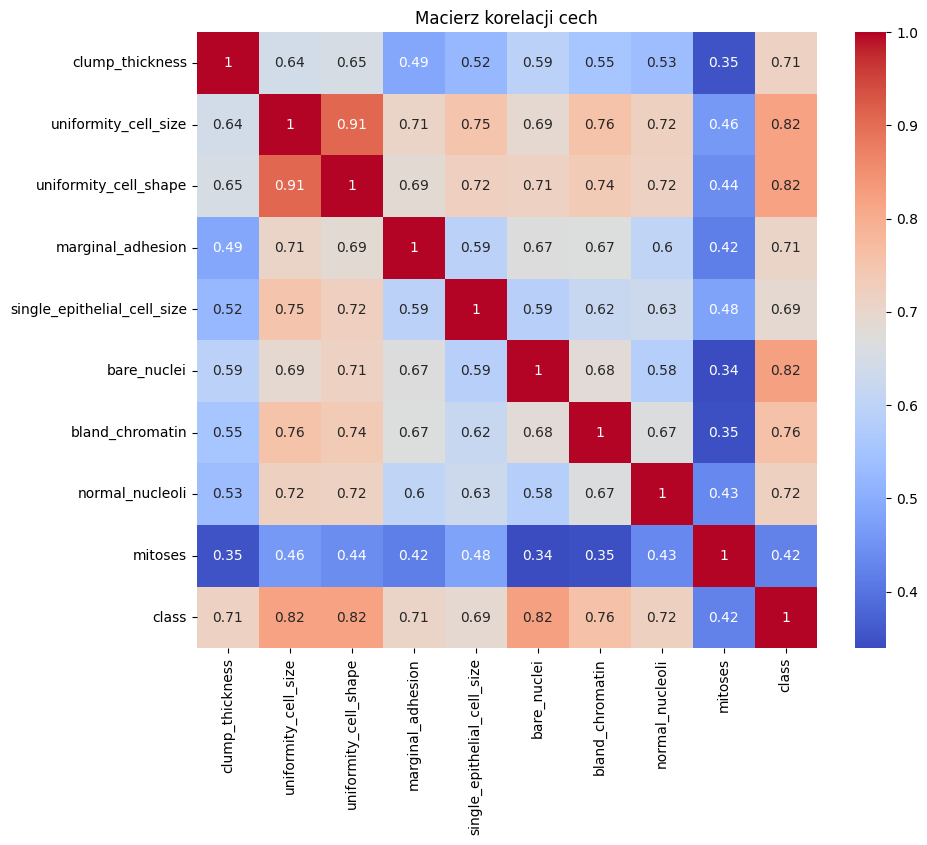

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Macierz korelacji cech")
plt.show()

Macierz korelacji przedstawia współczynniki korelacji Pearsona między wszystkimi parami zmiennych.
#### Kluczowe zależności:
- `uniformity_cell_size` a `uniformity_cell_shape`: 0.91 – bardzo silna kolinearność.
- `bare_nuclei` a `class`: 0.82
- `uniformity_cell_size` a `class`: 0.82
- `uniformity_cell_shape` a `class`: 0.82
- `bland_chromatin` a `class`: 0.76
- `mitoses` a `class`: 0.42 – słaba korelacja


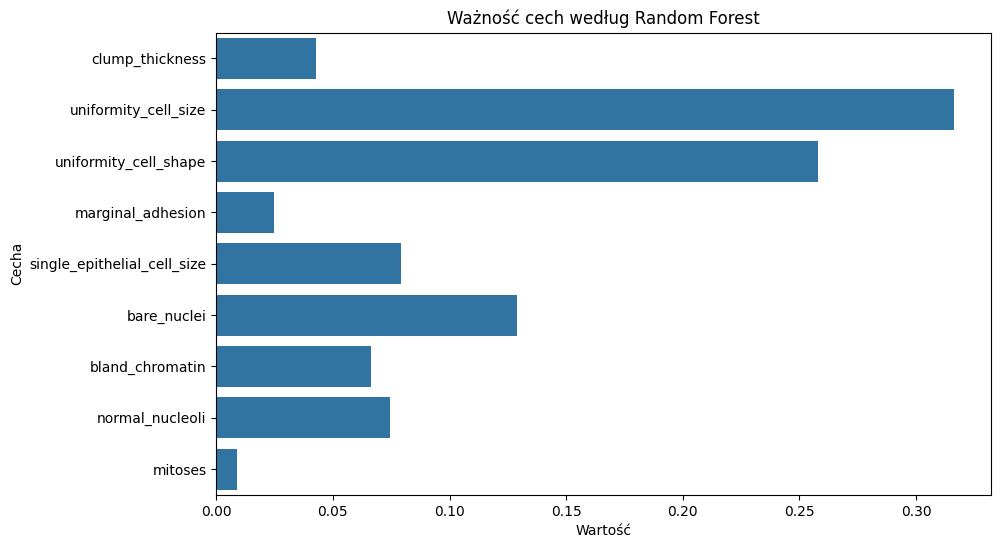

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X = df.drop(columns=['class'])
y = df['class']

model = RandomForestClassifier(random_state=42)
model.fit(X, y)

importances = model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title("Ważność cech według Random Forest")
plt.xlabel("Wartość")
plt.ylabel("Cecha")
plt.show()

Poniższy wykres przedstawia względne znaczenie każdej cechy wejściowej dla klasyfikatora Random Forest. Wartości te odzwierciedlają wpływ danej zmiennej na dokładność modelu.
#### Najważniejsze cechy:
- `uniformity_cell_size` (~0.31): najistotniejsza cecha, silnie związana z nowotworem złośliwym.
- `uniformity_cell_shape` (~0.26): druga co do istotności.
- `bare_nuclei` (~0.13): istotna cecha patologiczna.
- `single_epithelial_cell_size`, `bland_chromatin`, `normal_nucleoli`: cechy średniego znaczenia.
- `clump_thickness`: niewielkie znaczenie.
- `mitoses`: najmniejsze znaczenie.

# Wizualizacja i analiza zależności

## Rozkład cech

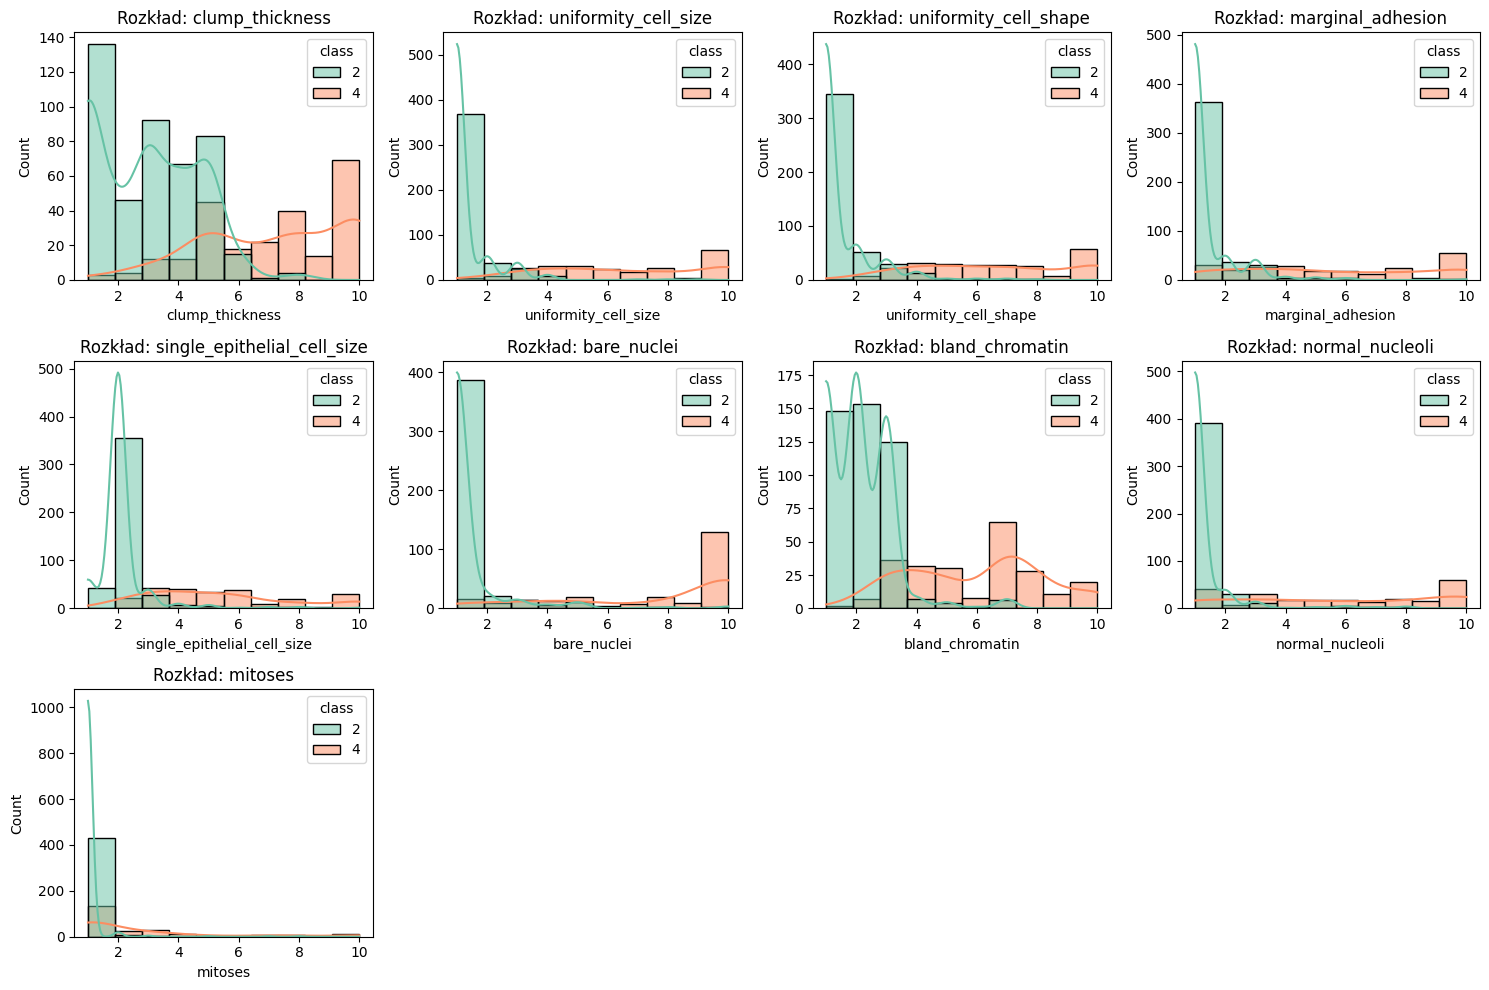

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

features = df.columns[:-1]

plt.figure(figsize=(15, 10))
for i, col in enumerate(features):
    plt.subplot(3, 4, i + 1)
    sns.histplot(data=df, x=col, kde=True, hue="class", palette='Set2', bins=10)
    plt.title(f'Rozkład: {col}')
plt.tight_layout()
plt.show()

<ipython-input-24-446c2a982bdb>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y=col, data=df, palette='Set3')
<ipython-input-24-446c2a982bdb>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y=col, data=df, palette='Set3')
<ipython-input-24-446c2a982bdb>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y=col, data=df, palette='Set3')
<ipython-input-24-446c2a982bdb>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` an

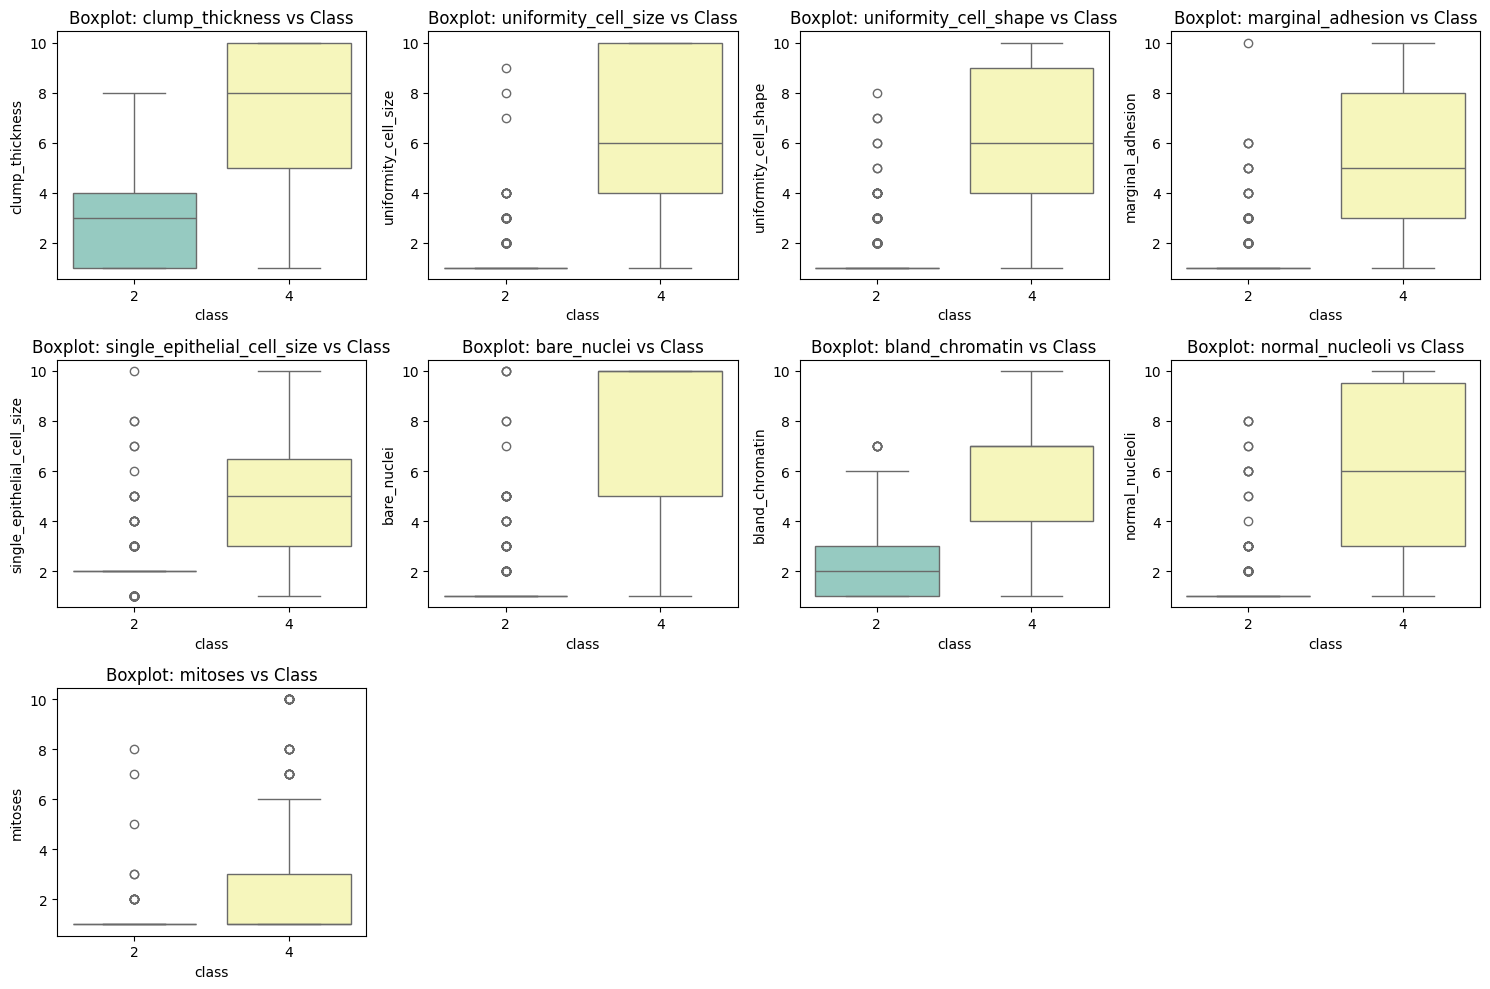

In [ ]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(features):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(x='class', y=col, data=df, palette='Set3')
    plt.title(f'Boxplot: {col} vs Class')
plt.tight_layout()
plt.show()

## Eksploracyjna analiza danych (EDA)

W ramach eksploracyjnej analizy danych przeanalizowano rozkłady cech i ich zdolność do rozróżnienia między klasą 2 (łagodny guz) a klasą 4 (złośliwy guz), korzystając z **histogramów** oraz **boxplotów**.

### Wnioski z analizy wizualnej:

- **Cechy najbardziej diagnostyczne:**  
  `uniformity_cell_size`, `uniformity_cell_shape`, `bare_nuclei`, `bland_chromatin` oraz `normal_nucleoli` wykazują wyraźne różnice w rozkładach między klasami. Dla guzów złośliwych obserwujemy wyższe wartości tych cech, co świadczy o ich dużej wartości predykcyjnej.

- **Rozdzielczość klas:**  
  Wykresy boxplot wskazują na dobrą separację klas, zwłaszcza w przypadku cech `uniformity_cell_size` i `uniformity_cell_shape`. Oznacza to, że klasy można skutecznie oddzielić za pomocą modeli klasyfikacyjnych.

- **Mało użyteczne cechy:**  
  `mitoses` charakteryzuje się bardzo niską zmiennością i podobnym rozkładem w obu klasach, co ogranicza jej przydatność w modelowaniu.

- **Charakterystyka klas:**  
  Klasa 2 (łagodna) ma rozkłady skupione wokół niższych wartości, natomiast klasa 4 (złośliwa) charakteryzuje się szerszymi, z licznymi wartościami odstającymi.

Analiza rozkładów cech za pomocą histogramów i boxplotów potwierdza, że dane są dobrze przygotowane do dalszej pracy. Cechy wykazują silną separowalność klas, co powinno przełożyć się na wysoką skuteczność modeli predykcyjnych.


# Przygotowanie danych do modelowania



## Standaryzacja i podział danych

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=['class'])
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Rozkład klas w zbiorze treningowym:")
print(y_train.value_counts())

Rozkład klas w zbiorze treningowym:
class
2    355
4    191
Name: count, dtype: int64


## Balansowanie klas (SMOTE)

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Rozkład klas po SMOTE:")
print(y_train_resampled.value_counts())

Rozkład klas po SMOTE:
class
2    355
4    355
Name: count, dtype: int64



- W oryginalnym zbiorze treningowym klasa 2 (łagodny guz) jest znacznie liczniejsza niż klasa 4 (złośliwy guz), co wskazuje na problem niezbalansowanych danych.
- Zastosowanie metody **SMOTE** pozwoliło na wyrównanie liczby próbek obu klas, co jest korzystne dla treningu modeli klasyfikacyjnych, ponieważ zapobiega uprzedzeniom modelu wobec dominującej klasy.
- Dzięki zbalansowaniu klas model ma większą szansę na lepszą generalizację i poprawę skuteczności klasyfikacji klasy mniejszościowej (klasy 4).

# PCA

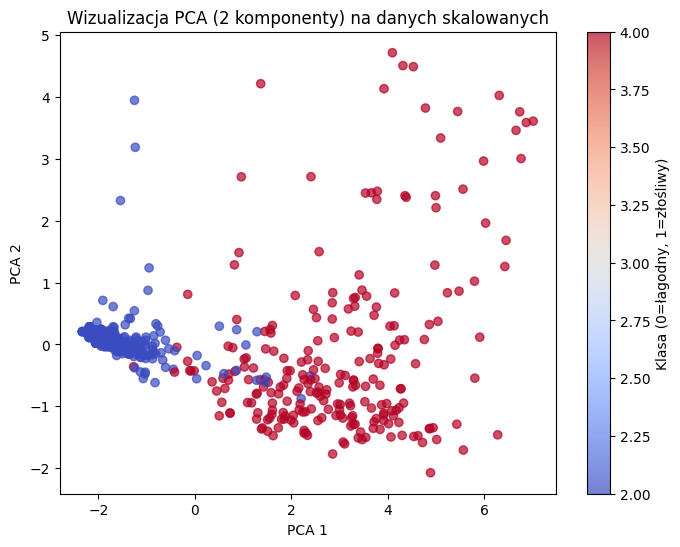

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.7)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Wizualizacja PCA (2 komponenty) na danych skalowanych')
plt.colorbar(scatter, label='Klasa (0=łagodny, 1=złośliwy)')
plt.show()

Wykres przedstawia dane po redukcji wymiarowości metodą **PCA** do dwóch głównych składowych (PCA1, PCA2) na danych skalowanych.

- Każdy punkt to próbka, kolor odpowiada klasie:
 - niebieskie – łagodne (class=2),
 - czerwone – złośliwe (class=4).
- Osie PCA reprezentują nowe wymiary, które zachowują największą zmienność danych.

#### Wnioski:

1. **Wyraźna separacja klas** – Większość przypadków łagodnych skupia się w lewej dolnej części wykresu, złośliwe są rozproszone w prawej i górnej części.
2.  **Dane są dobrze separowalne**  - Redukcja wymiarowości za pomocą PCA pokazuje, że cechy wyjściowe dobrze odróżniają obie klasy, co sugeruje wysoką skuteczność nawet prostych modeli klasyfikacyjnych.
3. **Nieliczne przypadki trudne do klasyfikacji**  - Kilka punktów niebieskich wśród czerwonych i odwrotnie to przypadki graniczne lub potencjalne błędy klasyfikacji.
4. **Znaczenie dla modelowania**  - Tak wyraźna separacja wskazuje, że zbiór jest bardzo dobrze przygotowany do budowy skutecznych modeli predykcyjnych.


# Eksploracja metod uczenia maszynowego



## Trenowanie modeli i ocena

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    results[name] = {
        "accuracy": acc,
        "precision": report["weighted avg"]["precision"],
        "recall": report["weighted avg"]["recall"],
        "f1-score": report["weighted avg"]["f1-score"]
    }
    print(f"=== {name} ===")
    print(classification_report(y_test, y_pred))

=== Logistic Regression ===
              precision    recall  f1-score   support

           2       0.99      0.96      0.97        89
           4       0.92      0.98      0.95        48

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.96      0.96      0.96       137

=== Random Forest ===
              precision    recall  f1-score   support

           2       1.00      0.96      0.98        89
           4       0.92      1.00      0.96        48

    accuracy                           0.97       137
   macro avg       0.96      0.98      0.97       137
weighted avg       0.97      0.97      0.97       137

=== KNN ===
              precision    recall  f1-score   support

           2       0.99      0.96      0.97        89
           4       0.92      0.98      0.95        48

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg

Porównanie wyników modeli

In [ ]:
import pandas as pd

results_df = pd.DataFrame(results).T
results_df = results_df.round(3)
results_df.sort_values(by="f1-score", ascending=False)

,accuracy,precision,recall,f1-score
Random Forest,0.971,0.973,0.971,0.971
Logistic Regression,0.964,0.965,0.964,0.964
KNN,0.964,0.965,0.964,0.964
SVM,0.964,0.965,0.964,0.964


## Wnioski

- Najlepszy wynik osiągnął model **Random Forest**, uzyskując najwyższe wartości F1-score zarówno dla klasy łagodnej (0.98), jak i złośliwej (0.96), a także najwyższą ogólną **dokładność: 97%**.
- Wszystkie przetestowane modele (Logistic Regression, KNN, SVM) osiągnęły **dokładność 96%**, co świadczy o bardzo dobrej jakości danych i wysokiej skuteczności klasyfikacji.
- Modele Logistic Regression, KNN i SVM uzyskały **wysoki recall dla klasy 4 (złośliwej)** — 0.98, co oznacza, że dobrze wykrywają przypadki złośliwego guza, co jest szczególnie istotne w zastosowaniach medycznych.
- Model Random Forest jako jedyny osiągnął **recall = 1.00 dla klasy 4**, co oznacza, że nie popełnił żadnego błędu przy rozpoznawaniu złośliwych guzów – jest to **kluczowa zaleta tego modelu** w kontekście wczesnego wykrywania raka.
- Dzięki zastosowaniu metody **SMOTE** dane zostały zbalansowane, co pozwoliło uniknąć uprzedzeń modelu wobec klasy dominującej i uzyskać **równe traktowanie obu klas**.
- Najbardziej informacyjne cechy mające największy wpływ na predykcję to:
  - `bare_nuclei`
  - `uniformity_cell_size`
  - `clump_thickness`
  - `uniformity_cell_shape`
  - `bland_chromatin`
- Modele są **wiarygodne**, skutecznie odróżniają guzy łagodne od złośliwych i dobrze generalizują do danych testowych.
- Wysokie wartości precyzji i recall potwierdzają, że klasy są dobrze rozróżnialne, a modele mogą być z powodzeniem wykorzystywane do wspomagania diagnostyki.


## Ewaluacja i kalibracja modeli


Macierz pomyłek i ROC/AUC

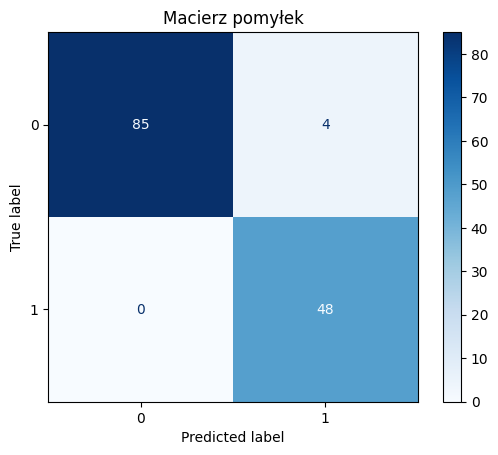

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

best_model = RandomForestClassifier(random_state=42)
best_model.fit(X_train_resampled, y_train_resampled)
y_pred = best_model.predict(X_test_scaled)
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Macierz pomyłek")
plt.show()

Macierz pomyłek pokazuje, jak model klasyfikacyjny radzi sobie z przewidywaniem dwóch klas:

- Wiersze odpowiadają rzeczywistym klasom (0 – łagodny guz, 1 – złośliwy).
- Kolumny odpowiadają klasom przewidzianym przez model.

- **85 przypadków** łagodnych guzów zostało poprawnie sklasyfikowanych .
- **48 przypadków** złośliwych guzów zostało poprawnie sklasyfikowanych .
- **4 przypadki** łagodnych guzów zostały błędnie zaklasyfikowane jako złośliwe.
- **0 przypadków** złośliwych guzów zostało błędnie sklasyfikowane jako łagodne.

#### Wnioski:

- Model **nigdy nie popełnił błędu**, który mógłby zlekceważyć nowotwór złośliwy, to bardzo ważne z punktu widzenia bezpieczeństwa pacjenta.
- Jedynym błędem są fałszywie pozytywne wyniki, czyli przypadki, w których model przewidział nowotwór złośliwy, mimo że był łagodny (lepiej pomylić się w tę stronę niż odwrotnie).
- Ogólna skuteczność modelu jest bardzo wysoka (Accuracy = (85+48)/137 ≈ 96.4%).

# Podsumowanie projektu

Celem projektu było stworzenie modelu uczenia maszynowego do predykcji rodzaju guza piersi (łagodny vs. złośliwy) na podstawie cech komórek uzyskanych z biopsji cienkoigłowej. Do analizy wykorzystano zbiór danych Breast Cancer Wisconsin z UCI, który po oczyszczeniu i przygotowaniu zawierał 683 obserwacje i 9 cech opisujących charakterystykę komórek.

W ramach projektu przeprowadzono kompleksową eksploracyjną analizę danych (EDA), która potwierdziła, że cechy takie jak `uniformity_cell_size`, `uniformity_cell_shape` oraz `bare_nuclei` mają wysoką wartość predykcyjną i wyraźnie różnicują klasy łagodną i złośliwą.

Ze względu na niezbalansowanie klas zastosowano metodę **SMOTE**, która wyrównała liczebność próbek obu klas, co pozwoliło na trenowanie modeli o lepszej zdolności generalizacji i skuteczniejszym wykrywaniu guzów złośliwych.

Do klasyfikacji zastosowano cztery popularne modele: regresję logistyczną, las losowy (Random Forest), k najbliższych sąsiadów (KNN) oraz maszynę wektorów nośnych (SVM). Najlepsze wyniki osiągnął model **Random Forest**, który uzyskał 97% dokładności oraz idealny `recal` dla klasy złośliwej, co oznacza brak fałszywych negatywów – niezwykle istotne w diagnostyce medycznej.

Podsumowując, opracowany model jest skutecznym narzędziem wspierającym diagnostykę raka piersi, wykazując wysoką precyzję i czułość.